# Stochastic Gradient Descent
- 배치 경사 하강법 의 경우 global minimum으로 나아가는 단계마다 전체 training set을 다시 평가
    - dataset이 거대한 경우 계산 비용이 많이 요구하기 때문에 수렴(훈련) 속도 느림
- 모든 sample에 대해 누적된 오차의 합을 기반으로 가중치를 업데이트 하지 않고 각 훈련 샘플에 대해 조금씩 가중치를 갱신<br>

*mini batch gradient descent: 한번에 여러 샘플을 묶음으로 학습시키는 것으로 수렴을 더 빠르게, sgd보다 계산 효율을 더 좋게*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
class AdalineSGD(object):
    """
    Adaline with SGD
    __________
    eta : float
        학습률 (0.0 ~ 1.0 사이의 값)
    n_iter : int
        훈련 dataset 반복 횟수
    shuffle : bool (default: True)
        True일 때 epcoh 마다 training set을 섞음
    random_state : int
        가중치 무작위 초기화를 위한 난수 생성기 seed
    
    __________
    w_ : 1d-array
        학습된 가중치
    cost_ : list
        epcoh마다 누적된 비용 함수의 제곱합
    
    """
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False # weight가 초기화 되어 있지 않을 때
        self.shuffle = shuffle
        self.random_state = random_state
    
    def fit(self, X, y):
        """
        Training
        
        __________
        X : {array-like}, shape = [n_samples, n_features]
            n_samples개의 sample과 n_features개의 특징으로 이루어진 train data
        y : array-like, shape = [n_samples]
            target 값
        
        __________
        self : object
        
        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
        return self
    
    def partial_fit(self, X, y):
        """가중치를 초기화 하지 않고 훈련 데이터를 학습"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(xi, target)
        return self
    
    def _shuffle(self, X, y):
        """training data shuffle"""
        r = self.rgen.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """가중치 초기화"""
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=1+m)
        self.w_initialized = True
    
    def _update_weights(self, xi, target):
        """adaline에 따라 업데이트"""
        output = self.activation(self.net_input(xi))
        error = target - output
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error**2
        return cost
        
    def net_input(self, X):
        """최종 입력 계산"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        """선형 활성화 계산"""
        return X
    
    def predict(self, X):
        """단위 계단 함수를 이용하여 class label 반환"""
        return np.where(self.net_input(X) >= 0.0, 1, -1)

In [3]:
def plot_decision_regions(X, y, classifier, resolution=0.02):
    
    markers = ('s','o','x','^','v')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=colors[idx], marker=markers[idx], label=cl, edgecolor='black')

In [4]:
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)

y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)

X = df.iloc[0:100, [0, 2]].values

In [5]:
X_std = np.copy(X)
X_std[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X_std[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

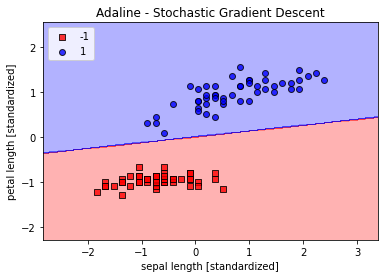

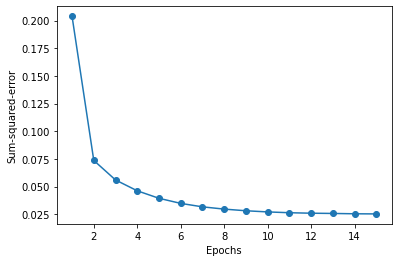

In [6]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)

plot_decision_regions(X_std, y, classifier=ada)
plt.title('Adaline - Stochastic Gradient Descent')
plt.xlabel('sepal length [standardized]')
plt.ylabel('petal length [standardized]')
plt.legend(loc='upper left')
plt.show()

plt.plot(range(1, len(ada.cost_)+1), ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.show()